In [24]:
import requests
import json
import re
import requests
import json
import datetime

codigo_ibge = "5300108"
url = f"https://apiprevmet3.inmet.gov.br/previsao/{codigo_ibge}"

# Função para saber se a data é futura ou presente
def is_future_or_today(date_str):
    dia, mes, ano = map(int, date_str.split('/'))
    data_obj = datetime.date(ano, mes, dia)
    hoje = datetime.date.today()
    return data_obj >= hoje

# Carregar arquivo existente, se houver
try:
    with open("inmet_brasilia.json", "r", encoding="utf-8") as f:
        data_antiga = json.load(f)
except FileNotFoundError:
    data_antiga = {codigo_ibge: {}}

# Baixar dados novos
response = requests.get(url)
data_nova = response.json()

# Novo dicionário para salvar
data_final = {codigo_ibge: {}}

# Copia os dias antigos (passados) do arquivo velho, mantém eles
for data_dia, valores in data_antiga.get(codigo_ibge, {}).items():
    if not is_future_or_today(data_dia):
        data_final[codigo_ibge][data_dia] = valores

# Atualiza/adiciona os dias atuais e futuros com os dados novos
for data_dia, valores in data_nova[codigo_ibge].items():
    # Sempre sobrescreve o hoje e o futuro
    data_final[codigo_ibge][data_dia] = valores

# Salva o arquivo final
with open("inmet_brasilia.json", "w", encoding="utf-8") as f:
    json.dump(data_final, f, ensure_ascii=False, indent=2)

print("Arquivo atualizado! Dias antigos preservados, previsões atuais e futuras sobrescritas/adicionadas.")


Arquivo atualizado! Dias antigos preservados, previsões atuais e futuras sobrescritas/adicionadas.


In [25]:
# Extrair dados da cidade pelo código
cidade = "5300108"
dias = []

for data_dia, periodos in data[cidade].items():
    if re.match(r"\d{2}/\d{2}/\d{4}", data_dia):
        if isinstance(periodos, dict) and any(p in periodos for p in ['manha', 'tarde', 'noite']):
            # Pega todos os temp_max e temp_min dos períodos
            temp_maxs = []
            temp_mins = []
            for periodo_nome, info in periodos.items():
                if isinstance(info, dict):
                    if 'temp_max' in info:
                        temp_maxs.append(info['temp_max'])
                    if 'temp_min' in info:
                        temp_mins.append(info['temp_min'])
            # Seleciona maior temp_max e menor temp_min
            if temp_maxs and temp_mins:
                linha = {
                    'data': data_dia,
                    'temp_max': max(temp_maxs),
                    'temp_min': min(temp_mins)
                }
                dias.append(linha)
        # Se já é diário
        elif isinstance(periodos, dict):
            if 'temp_max' in periodos and 'temp_min' in periodos:
                linha = {
                    'data': data_dia,
                    'temp_max': periodos['temp_max'],
                    'temp_min': periodos['temp_min']
                }
                dias.append(linha)

# Converte para DataFrame final
df_diario = pd.DataFrame(dias)
print(df_diario)


NameError: name 'data' is not defined

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance_from_point_to_station(row, given_point_coord):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    # given_point_coord = (-15.789343, -47.925756)
    return geodesic(station_coord, given_point_coord).kilometers

df_all_stations = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

# given_point_coord = (-16.012222, -47.557417)
# df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, given_point_coord), axis=1) 

# df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 50]

# df_point_stations = df_all_stations[df_all_stations["Distancia"] < 1]

# Estaçoes do DF
codes_of_stations_to_analyze = ["A001", "A042", "A045", "A046", "A047"]

stations_data = []

# stations_files_to_read = set()

for code in codes_of_stations_to_analyze:
    station_info = df_all_stations[df_all_stations["CODIGO (WMO):"] == code]

    latitude = station_info["LATITUDE:"].iloc[0]
    longitude = station_info["LONGITUDE:"].iloc[0]

    station_coord = (latitude, longitude)

    df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, station_coord), axis=1) 
    df_nearest_stations = df_all_stations[(df_all_stations["Distancia"] != 0) & (df_all_stations["Distancia"] < 50)]

    station_data = { 
        "code": code,
        "station_info": station_info,
        "nearest_stations_info": df_nearest_stations,
    }

    # df_nearest_stations["Arquivo"].apply(lambda x: stations_files_to_read.add(x))
    # stations_files_to_read.add(station_info["Arquivo"].iloc[0])
    stations_data.append(station_data)

print(stations_data)
# print(stations_files_to_read)

[{'code': 'A001', 'station_info':     REGI?O: UF:  ESTAC?O: CODIGO (WMO):   LATITUDE:  LONGITUDE: ALTITUDE:  \
442      CO  DF  BRASILIA          A001  -15.789343  -47.925756   1160.96   

                                               Arquivo  
442  INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2...  , 'nearest_stations_info':     REGI?O: UF:            ESTAC?O: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
2        CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
141      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   
233      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
239      CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   

    ALTITUDE:                                            Arquivo  Distancia  
2      1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019...  46.520207  
141    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12...  30.411300  
233   1030.36  INMET_CO_DF_A045

In [26]:
# yeardirectoryfilename = []
# df_nearest_stations_weather_data = []

# stations_dataframes = {
    
# }

def read_station_data(filename, start_year, end_year):
    station_data = []

    for year in range(start_year, end_year + 1):
        file = f'../data/cleaned_data/{year}_cleaned/{filename.replace("2019", str(year))}'
        df_weather_data = pd.read_csv(file, decimal=".", sep=";")
        station_data.append(df_weather_data)

    return pd.concat(station_data, ignore_index= True)

for station in stations_data:
    station_info = station["station_info"]
    station_file_name = station_info["Arquivo"].iloc[0]

    station["station_data"] = read_station_data(station_file_name, 2019, 2024)

    nearest_stations_data = []
    for index, nearest_station in station["nearest_stations_info"].iterrows():
        nearest_station_file_name = nearest_station["Arquivo"]
        nearest_station_data = read_station_data(nearest_station_file_name, 2019, 2024)

        nearest_stations_data.append(nearest_station_data)

    nearest_stations_data_compilation = pd.concat(nearest_stations_data, ignore_index= True)

    station["nearest_stations_data"] = nearest_stations_data_compilation

                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1753
Model:                                           ARIMA(1, 0, 0)   Log Likelihood               -1849.735
Date:                                          Tue, 10 Jun 2025   AIC                           3729.471
Time:                                                  16:18:54   BIC                           3811.507
Sample:                                              01-01-2019   HQIC                          3759.794
                                                   - 10-19-2023                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1753
Model:                                           ARIMA(1, 0, 0)   Log Likelihood               -1926.233
Date:                                          Tue, 10 Jun 2025   AIC                           3882.467
Time:                                                  16:19:10   BIC                           3964.503
Sample:                                              01-01-2019   HQIC                          3912.790
                                                   - 10-19-2023                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

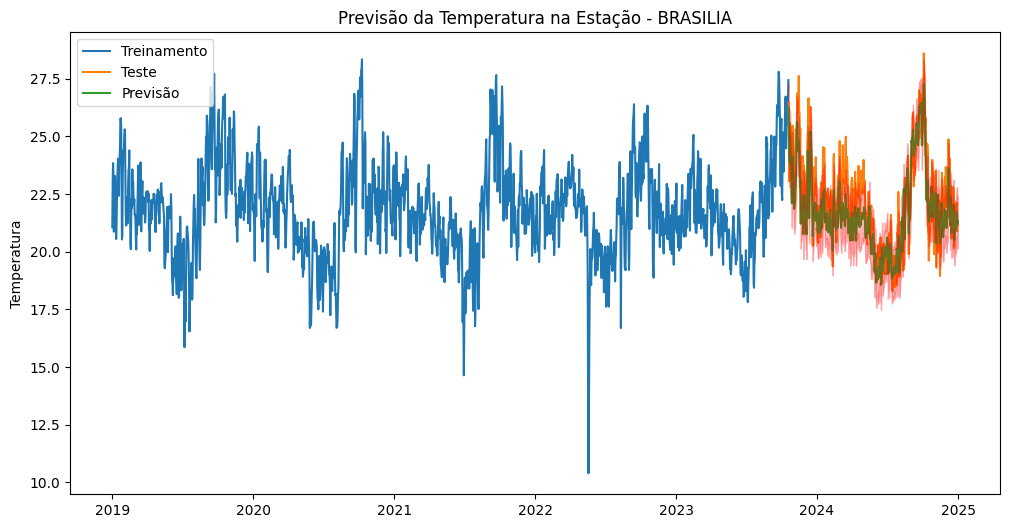

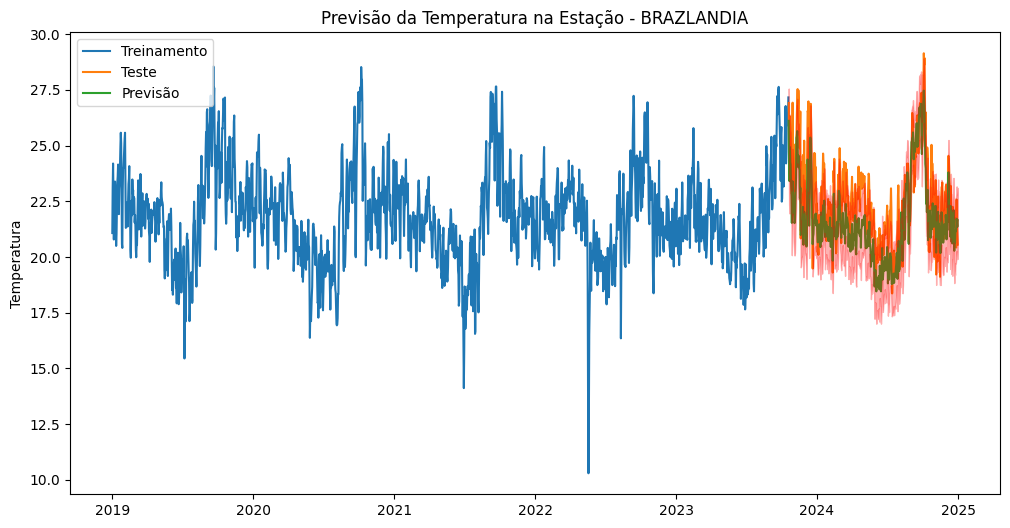

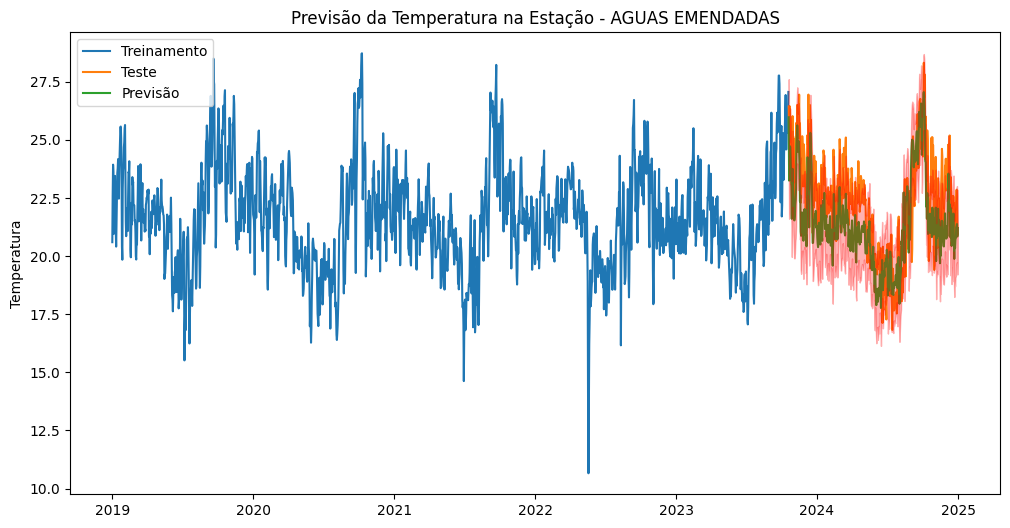

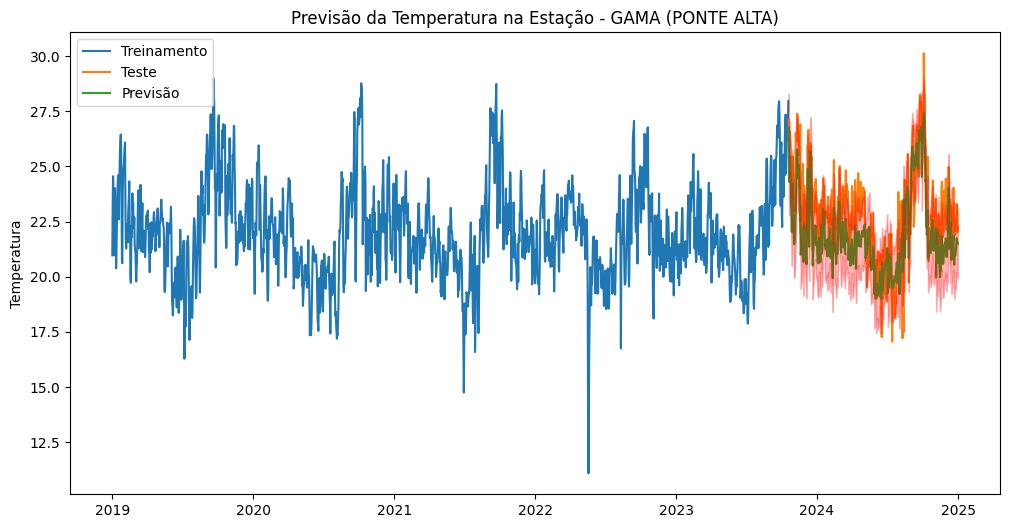

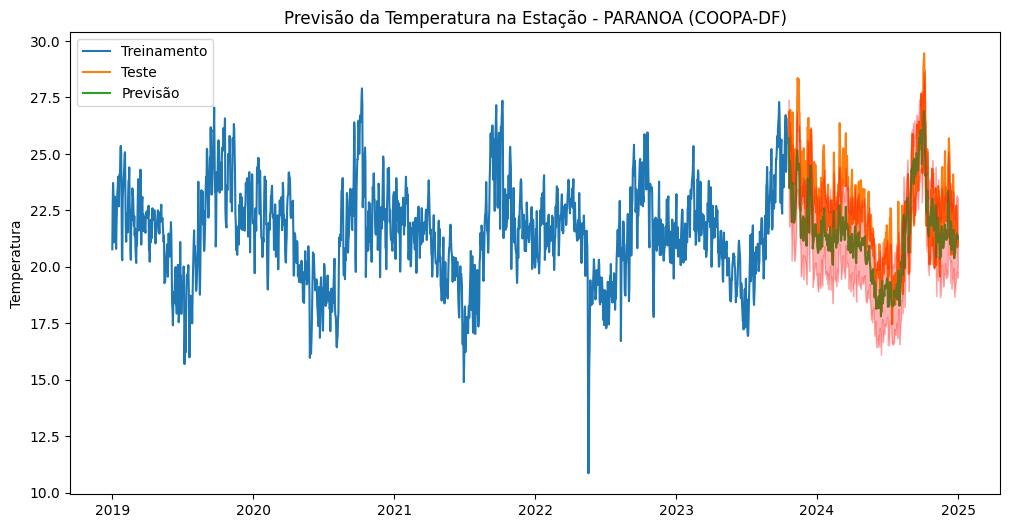

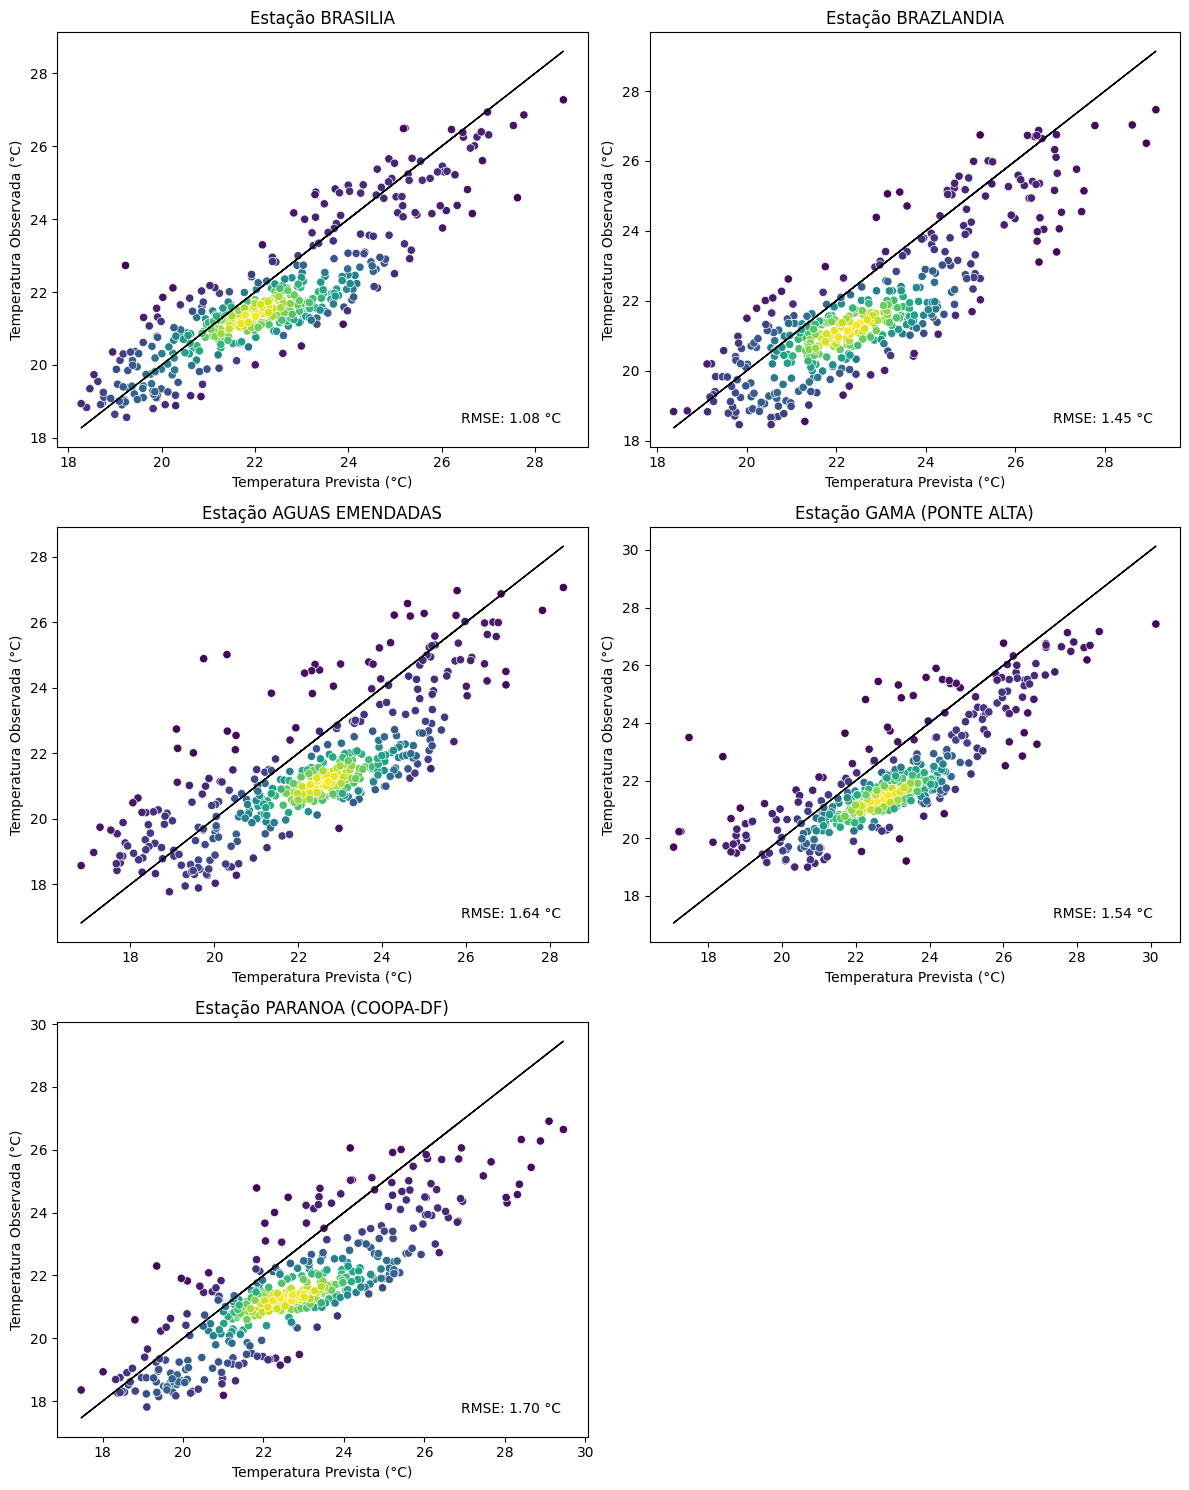

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns

from pmdarima import auto_arima

# df_nearest_stations_weather_data = []

# for filename in df_nearest_stations['Arquivo']: 
#     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
#     df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

def clean_data(dataframe):
    df_cleaned = dataframe.drop(columns=['Hora UTC'])
    df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

    df_sorted = df_cleaned.sort_values(by='Data', ascending=True)
    df_sorted.set_index('Data', inplace=True)
    df_avarage_temperature_by_day = df_sorted.resample("D").mean()
    df_not_null_values_day = df_avarage_temperature_by_day.ffill()

    return df_not_null_values_day

def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def get_forecast_test_graph(df_test, forecast, forecast_parameter, ax):
    import numpy as np
    from scipy import stats
    from sklearn.metrics import mean_squared_error
    import seaborn as sns

    values = np.vstack([df_test[forecast_parameter], forecast])
    kernel = stats.gaussian_kde(values)(values)

    # Scatterplot com seaborn no eixo fornecido
    sns.scatterplot(
        x=df_test[forecast_parameter],
        y=forecast,
        hue=kernel,
        palette="viridis",
        ax=ax,
        legend=False
    )

    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5

    # Linha de referência x=y
    ax.plot(df_test[forecast_parameter], df_test[forecast_parameter], color='black', linewidth=1.0)

    # Texto RMSE
    ax.text(0.95, 0.05, f'RMSE: {rmse:.2f} °C', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

    ax.set_ylabel('Temperatura Observada (°C)')
    ax.set_xlabel('Temperatura Prevista (°C)')

def get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name):
    n_graphs = len(df_tests)
    n_cols = 2
    n_rows = (n_graphs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i in range(n_graphs):
        get_forecast_test_graph(df_tests[i], forecasts[i], forecast_parameter, ax=axes[i])
        axes[i].set_title(f'Estação {stations_name[i]}')

    # Remove os eixos extras se n_graphs for ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    exog_vars = ["RADIACAO GLOBAL (KJ/m²)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)", "UMIDADE RELATIVA DO AR, HORARIA (%)"]

    X_train_extra = df_training[exog_vars].values
    X_test_extra = df_test_without_the_station[exog_vars].values

    X_train_final = np.hstack([X_train_extra, fourier_terms[:n]])

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=X_train_final, order=(1,0,0), trend='ct')
    model_fit = model.fit()

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    X_test_final = np.hstack([X_test_extra, forecast_exog])

    # Get the forecast for the future steps with exogenous variables
    # forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=X_test_final)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    return forecast

forecasts = []
df_tests = []
stations_name = []
forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
for station in stations_data:
    cleaned_station_data = clean_data(station["station_data"])
    cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


    # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
    training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
    df_training = cleaned_nearest_stations_data[:training_data_length]
    df_test_without_the_station = cleaned_nearest_stations_data[training_data_length:]
    df_test = cleaned_station_data[training_data_length:]

    station_name = station["station_info"]["ESTAC?O:"].iloc[0]
    forecast = arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
    # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

    forecasts.append(forecast)
    df_tests.append(df_test)
    stations_name.append(station_name)


get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)

 